In [5]:
import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm
from pytorch_forecasting import TimeSeriesDataSet, Baseline, TemporalFusionTransformer
from pytorch_forecasting.data import TorchNormalizer
from pytorch_forecasting.metrics import MAPE, MAE
import torch
import torch.nn.functional as F
import lightning as pl
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import tensorboard as tb


In [6]:
#load data
data = pd.read_parquet('/content/gdrive/MyDrive/2024MASTERTHEIS/TFT_notebooks/data/data_DE_TENNET.parquet', engine='pyarrow')
data.columns
data.reset_index(drop=True, inplace=True)

In [7]:
data.columns

Index(['CO2_intensity_in_gCO2_per_KWh', 'Total_Emissions_in_kg',
       'Total_Generation', 'Biomass', 'Fossil Brown coal/Lignite',
       'Fossil Gas', 'Fossil Hard coal', 'Fossil Oil', 'Geothermal',
       'Hydro Pumped Storage', 'Hydro Run-of-river and poundage',
       'Hydro Water Reservoir', 'Nuclear', 'Other', 'Other renewable', 'Solar',
       'Waste', 'Wind Offshore', 'Wind Onshore', 'day_ahead_price',
       'radiation_global', 'sunshine_duration', 'temperature_air_mean_200',
       'temperature_dew_point_mean_200', 'wind_direction', 'wind_speed',
       'sin_day_of_week', 'cos_day_of_week', 'sin_hour_of_day',
       'cos_hour_of_day', 'sin_day_of_year', 'cos_day_of_year', 'hour_of_day',
       'day_of_month', 'day_of_year', 'month_of_year', 'week_of_year',
       'day_of_week', 'quarter_of_year', 'time_idx', 'GroupKey', 'total_ren',
       'total_conv', 'share_ren'],
      dtype='object')

In [9]:
#rename target column
data.rename(columns={'CO2_intensity_in_gCO2_per_KWh':'target'}, inplace=True)

max_prediction_length = 24 # predict max 1 day ahead
max_encoder_length = 24*28 #last 28 days #reference Riekstin

# Sets limit for training data (last index prior to max prediction sequence)
training_cutoff = data["time_idx"].max() - 365 * max_prediction_length

train_df = data[data["time_idx"] <= training_cutoff]
test_df = data[data["time_idx"] > training_cutoff]

In [1]:
# save test df
#test_df.to_parquet("data/test_tennet.parquet")

In [14]:
# define training data set
training = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx", # variable that contains the time index
    target="target", # target variable to predict
    group_ids=["GroupKey"], # Groups used for later normalizing
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length, # 24h to predict
    max_prediction_length=max_prediction_length, # 24h to predic
    static_categoricals=["GroupKey"], # they do not change along a same time index
    #static_reals=[], # same as before but real values
    time_varying_known_categoricals=['hour_of_day', 'day_of_month', 'day_of_year',
       'month_of_year', 'week_of_year', 'day_of_week', 'quarter_of_year',], # cats that change for same time idx
    #variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx",'sin_day_of_week', 'cos_day_of_week',
       'sin_hour_of_day', 'cos_hour_of_day', 'sin_day_of_year',
       'cos_day_of_year'],
    #time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'target', 'Total_Emissions_in_kg', 'Total_Generation', 'Biomass',
       'Fossil Brown coal/Lignite', 'Fossil Gas', 'Fossil Hard coal',
       'Fossil Oil', 'Geothermal', 'Hydro Pumped Storage',
       'Hydro Run-of-river and poundage', 'Hydro Water Reservoir', 'Nuclear',
       'Other', 'Other renewable', 'Solar', 'Waste', 'Wind Offshore',
       'Wind Onshore', 'day_ahead_price', 'radiation_global',
       'sunshine_duration', 'temperature_air_mean_200',
       'temperature_dew_point_mean_200', 'wind_direction', 'wind_speed',
       'total_ren','total_conv', 'share_ren'
    ], # values that are not supposed to be known in the future
    target_normalizer=TorchNormalizer(),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=False, # to add the center and scale of the unnormalized timeseries as features  TODO change to false
    add_encoder_length=True, # adds decoder length to list of static real variables.
)

In [15]:
validation = TimeSeriesDataSet.from_dataset(training, test_df, predict=True, stop_randomization=True)

In [16]:
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size)# , num_workers=7, persistent_workers=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size*10)# , num_workers=7, persistent_workers=True)

In [17]:
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAPE()(baseline_predictions.output, baseline_predictions.y)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

tensor(0.3623, device='cuda:0')

In [18]:
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="gpu",
    gradient_clip_val=0.1, #
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [19]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=8,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=MAPE(),
    optimizer="Adam"
)

print("Number of parameters in network:", tft.size())

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 27982


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 99 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 99 steps due to diverging loss.
INFO: Learning rate set to 0.001023292992280754
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.001023292992280754
INFO: Restoring states from the checkpoint path at /content/.lr_find_7a97f71c-961b-4bfa-a5f3-bc02aebf6453.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_7a97f71c-961b-4bfa-a5f3-bc02aebf6453.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_7a97f71c-961b-4bfa-a5f3-bc02aebf6453.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_7a97f71c-961b-4bfa-a5f3-bc02aebf6453.ckpt


Suggestions for learning rate: 0.001023292992280754


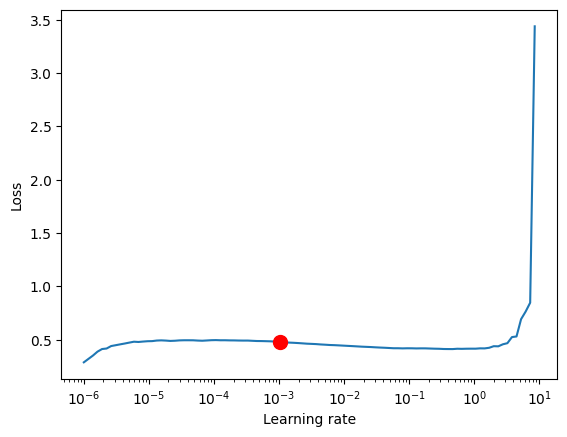

In [20]:
res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print("Suggestions for learning rate:", res.suggestion())
fig = res.plot(show=True, suggest=True)
fig.show()

In [21]:

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs_tennet")

# define parameter
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    #limit_train_batches=50,  # coment out for full training #uncomment for time series
    # fast_dev_run=True,  # comment out for full training
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)
#define model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=MAPE(), #loss function to MAPE
    log_interval=10,  # uncomment for logging to tensorboard
    optimizer="AdamW",
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in network: {tft.size()}")

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 57158


In [22]:
# Fit the model
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MAPE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 7.3 K 
3  | prescalers                         | ModuleDict                      | 608   
4  | static_variable_selection          | VariableSelectionNetwork        | 624   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 27.9 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 7.5 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initia

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

'done <Response [200]>'

In [24]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(f"best model path {best_model_path}")
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

#### if not training is done, you can use the saved model 
#best_tft = TemporalFusionTransformer.load_from_checkpoint("best_tft_models/Best_tft_tennet_epoch=10-step=6138.ckpt")

best model path lightning_logs_tennet/lightning_logs/version_0/checkpoints/epoch=10-step=6138.ckpt


### Forecast on test data set and result export to file

In [26]:
test_dataset = test_df
##
columns = [
        'target', 'Total_Emissions_in_kg', 'Total_Generation', 'Biomass',
       'Fossil Brown coal/Lignite', 'Fossil Gas', 'Fossil Hard coal',
       'Fossil Oil', 'Geothermal', 'Hydro Pumped Storage',
       'Hydro Run-of-river and poundage', 'Hydro Water Reservoir', 'Nuclear',
       'Other', 'Other renewable', 'Solar', 'Waste', 'Wind Offshore',
       'Wind Onshore', 'day_ahead_price', 'radiation_global',
       'sunshine_duration', 'temperature_air_mean_200',
       'temperature_dew_point_mean_200', 'wind_direction', 'wind_speed',
       'total_ren','total_conv', 'share_ren'
    ]
# output into pandas df
test_dataset = test_df


max_encoder_length = 24*28
max_prediction_length = 24
target_name = 'target'
iteration = 0

addition_var = max_encoder_length + max_prediction_length

results_df = pd.DataFrame()

for i in range(0, len(test_dataset)-addition_var, max_prediction_length):
    print(i)
    new_pred_collection = []
    test_dataset_short = test_dataset.iloc[i : i + max_encoder_length]
    encoder_data = test_dataset_short[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

    test_dataset_decoder = test_dataset.iloc[i+ max_encoder_length : i + max_encoder_length + max_prediction_length]

    for col in columns:
        test_dataset_decoder[col] = 0.0
    decoder_data = test_dataset_decoder

    new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

    new_raw_predictions = best_tft.predict(new_prediction_data, mode="raw", return_x=True, return_index=True)

    fcast = new_raw_predictions.output.prediction[0].cpu().detach().numpy()
    tidx = new_raw_predictions[1]["decoder_time_idx"].cpu().detach().numpy()
    forecast_df = pd.DataFrame({
    "time_idx": tidx.flatten(),
    "forecast": fcast.flatten(),
    "iteration": iteration
        })
    merged_df = pd.merge(forecast_df, test_df[['time_idx', 'target']], on="time_idx", how="left")


    results_df = pd.concat([results_df, merged_df],axis=0)
    results_df.reset_index(drop=True, inplace=True)
    results_df.index = results_df["time_idx"]* np.timedelta64(1, 'h') + pd.Timestamp('2015-01-05 00:00:00+0100', tz='Europe/Berlin')
    iteration +=1
    display(results_df.head(5))

results_df.to_parquet("data/tft_results_test_tennet.parquet")

Output hidden; open in https://colab.research.google.com to view.